In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz
from simulate import *



import matplotlib 
matplotlib.rc('xtick', labelsize=27) 
matplotlib.rc('ytick', labelsize=27)

In [2]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
#from simulate import *
#from model import *
import pickle
from collections import defaultdict
import arviz


import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)

exoplanet.__version__ = '0.5.1'


In [2]:
def sim_orbit(roman_err, roman_duration):
    T_subtract = 2454000
    # orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
    # BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

    m_sun = 333030 #earth masses

    P_earth = 300
    e_earth = 0.0167
    Tper_earth= 100
    omega_earth = np.radians(102.9)
    Omega_earth = np.radians(0.0)
    inclination_earth = np.radians(45.)
    m_earth = 1./m_sun #units m_sun



    P_jup = 4327.
    e_jup = 0.0484
    Tper_jup = 500
    omega_jup = np.radians(274.3) - 2*np.pi
    Omega_jup = np.radians(100.4)
    inclination_jup = np.radians(1.31) + inclination_earth
    m_jup = 317.83/m_sun #units m_sun





    #add gaia observing times
    times_observed_astrometry_gaia = []
    t_0 = int(Tper_earth)
    for ii in range(t_0, t_0+3600):
        if ii % (3600/200) == 0:
            times_observed_astrometry_gaia.append(ii)



    #add THE observing times
    times_observed_rv = []
    t_0 = int(Tper_earth)
    add_data = True
    for ii in range(t_0, t_0+3600):

        if ii % 180 == 0:
            if add_data:
                add_data = False
            else:
                add_data = True

        if add_data:
            times_observed_rv.append(ii)


    orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
    orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

    n_planets = 2
    orbit_params = [orbit_params_earth, orbit_params_jup]


    sigma_rv = 0.3

    sigma_ra_gaia = 6e-5
    sigma_dec_gaia = 6e-5
    parallax = 0.1 #as



    times, rv_results, ra_results, dec_results = simulate_data(
        n_planets, 
        sigma_rv, 
        sigma_ra_gaia,
        sigma_dec_gaia,
        parallax,
        orbit_params,
        times_observed_rv = times_observed_rv,
        times_observed_astrometry = times_observed_astrometry_gaia
        )


    [[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
    [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
    [ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum],
    [dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]]  = times, rv_results, ra_results, dec_results

    ra_gaia_err = np.full(np.shape(ra_sim_sum), sigma_ra_gaia)
    dec_gaia_err = np.full(np.shape(dec_sim_sum), sigma_dec_gaia)


    #add roman observing times if roman_err not None
    if roman_duration is not None:
        t_1 =  times_observed_astrometry_gaia[-1]+1800
        times_observed_astrometry_roman = []
        for ii in range(t_1, t_1+(roman_duration*365)):
            if ii % 90 == 0:
                times_observed_astrometry_roman.append(ii)	


        sigma_ra_roman = roman_err
        sigma_dec_roman = roman_err



        times, rv_results, ra_results, dec_results = simulate_data(
            n_planets, 
            sigma_rv, 
            sigma_ra_roman,
            sigma_dec_roman,
            parallax,
            orbit_params,
            times_observed_rv = times_observed_rv,
            times_observed_astrometry = times_observed_astrometry_roman
            )

        times_astrometry = np.append(times_astrometry, times[2], axis=0)

        times_observed_astrometry = np.append(times_observed_astrometry, times[3], axis=0)

        ra_orbit = np.append(ra_orbit, ra_results[0], axis=0)
        ra_orbit_sum = np.append(ra_orbit_sum, ra_results[1], axis=0)
        ra_sim = np.append(ra_sim, ra_results[2], axis=0)
        ra_sim_sum = np.append(ra_sim_sum, ra_results[3], axis=0)

        dec_orbit = np.append(dec_orbit, dec_results[0], axis=0)
        dec_orbit_sum = np.append(dec_orbit_sum, dec_results[1], axis=0)
        dec_sim = np.append(dec_sim, dec_results[2], axis=0)
        dec_sim_sum = np.append(dec_sim_sum, dec_results[3], axis=0)

        ra_roman_err = np.full(np.shape(ra_results[3]), sigma_ra_roman)
        dec_roman_err = np.full(np.shape(dec_results[3]), sigma_dec_roman)



    ##################
    ##################
    ##################
    ##################
    #end simulate data
    ##################
    ##################
    ##################
    ##################
    ##################

    return times_rv, rv_orbit, times_astrometry, ra_orbit, dec_orbit

In [3]:
sim_folder = './simulated_data/March10_jup_and_saturn/'


sim_files = [
    'period4327_inc45_gaia60_roman5_5_100gaia.csv',
    'period4327_inc45_gaia60_roman5_5_200gaia.csv',
    'period4327_inc45_gaia60_roman5_10_100gaia.csv',
    'period4327_inc45_gaia60_roman5_10_200gaia.csv',
    
    'period4327_inc45_gaia60_roman10_5_100gaia.csv',
    'period4327_inc45_gaia60_roman10_5_200gaia.csv',
    'period4327_inc45_gaia60_roman10_10_100gaia.csv',
    'period4327_inc45_gaia60_roman10_10_200gaia.csv',
    
    'period4327_inc45_gaia60_roman20_5_100gaia.csv',
    'period4327_inc45_gaia60_roman20_5_200gaia.csv',
    'period4327_inc45_gaia60_roman20_10_100gaia.csv',
    'period4327_inc45_gaia60_roman20_10_200gaia.csv',
    
    'period4327_inc45_gaia60_romanNA_100gaia.csv',
    'period4327_inc45_gaia60_romanNA_200gaia.csv'
]


simulated_data = []
for file in sim_files:
    df = pd.read_csv(sim_folder + file)
    simulated_data.append(df)
    #print(simulated_data)
    

In [12]:
print(simulated_data[0].keys())

Index(['Unnamed: 0', 'x_rv', 'y_rv', 'y_rv_err', 'x_astrometry', 'y_ra',
       'y_dec', 'y_ra_err', 'y_dec_err'],
      dtype='object')


In [16]:
def make_plots(roman_vars, simulated_data, trace_file, trace_folder):
    
    
    #times_rv, rv_orbit, times_astrometry, ra_orbit, dec_orbit = sim_orbit(roman_vars[0], roman_vars[1])
    
    x_rv = simulated_data['x_rv'].values
    y_rv = simulated_data['y_rv'].values
    y_rv_err = simulated_data['y_rv_err'].values
    x_astrometry = simulated_data['x_astrometry'].values
    y_ra = simulated_data['y_ra'].values
    y_dec = simulated_data['y_dec'].values
    y_ra_err = simulated_data['y_ra_err'].values
    y_dec_err = simulated_data['y_dec_err'].values
          
    x_rv = x_rv[~np.isnan(x_rv)]
    y_rv = y_rv[~np.isnan(y_rv)]
    y_rv_err = y_rv_err[~np.isnan(y_rv_err)]
    x_astrometry = x_astrometry[~np.isnan(x_astrometry)]
    y_ra = y_ra[~np.isnan(y_ra)]
    y_dec = y_dec[~np.isnan(y_dec)]
    y_ra_err = y_ra_err[~np.isnan(y_ra_err)]
    y_dec_err = y_dec_err[~np.isnan(y_dec_err)]
    
    # make a fine grid that spans the observation window for plotting purposes
    t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
    t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

    # for predicted orbits
    t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)
    
    trace = arviz.from_netcdf(trace_folder+trace_file)
    
    
    
    
    ################
    #plot astrometry
    
    figAs, ax = plt.subplots(2, 2, figsize = [18,9], sharey=True)
    for n, letter in enumerate(["Jupiter", "Saturn"]):
        ax0, ax1 = ax[n][0], ax[n][1]

        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["dec"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )






        # plot the DEC data
        ax0.errorbar(x_astrometry, y_dec - other, yerr=y_dec_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)

        # plot the MCMC DEC model
        pred = np.percentile(
            trace.posterior["dec_fine"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1),
        )


        ax0.plot(t_fine, pred[1], color="k", label="MCMC model")
        art = ax0.fill_between(
            t_fine, pred[0], pred[2], color="k", alpha=0.3
        )
        art.set_edgecolor("none")

        # plot the true DEC model
        #ax0.plot(times_astrometry, dec_orbit.T[n], color = 'r', label = "true model")








        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["ra"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )
        





        # Plot the RA data
        ax1.errorbar(x_astrometry, y_ra - other, yerr=y_ra_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)


        pred = np.percentile(
            trace.posterior["ra_fine"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1), 
        )



        # plot the MCMC RA model
        ax1.plot(t_fine, pred[1], color="k", label="MCMC model")
        art = ax1.fill_between(
            t_fine, pred[0], pred[2], color="k", alpha=0.3
        )
        art.set_edgecolor("none")
        
        # plot the true RA model
        #ax1.plot(times_astrometry, ra_orbit.T[n], color = 'r', label = "true model")








        ax0.legend(fontsize=18, loc=3)
        ax0.set_xlabel("time [days]", fontsize=18)
        ax0.set_ylabel(r"$\Delta \delta$ ['']", fontsize = 18)
        ax0.set_title("{0} Dec".format(letter), fontsize=27)
        
        ax1.legend(fontsize=18, loc=3)
        ax1.set_xlabel("time [days]", fontsize=18)
        ax1.set_ylabel(r"$\Delta \alpha \cos \delta$ ['']", fontsize = 18)
        ax1.set_title("{0} RA".format(letter), fontsize=27)

        
        
        
        
        #ax[1].set_ylabel(r"[O-C]", fontsize = 36)
        #ax[3].set_ylabel(r"[O-C]", fontsize = 36)
        figAs.tight_layout()
        figAs.suptitle('Astrometry: ' + trace_file[:-4], fontsize=36)
        #fig.savefig('./comparison_figures2/astrometry_'+file+'.pdf')
        
        
        
        
        
            
        
        
    ######
    #make rv plots
    matplotlib.rc('xtick', labelsize=18) 
    matplotlib.rc('ytick', labelsize=18)
    change_to_NaN = False #creates gap in plot
    figRV, axs = plt.subplots(2, 1, figsize = [13, 9])
    for n, letter in enumerate(["Jupiter", "Saturn"]):
        ax = axs[n]

        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )







        # Plot the data
        ax.errorbar(x_rv, y_rv - other, yerr=y_rv_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)


        pred = np.percentile(
            trace.posterior["vrad_pred"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1),
        )

        #t_plot = t_fold[inds].copy()
        #for ii in range(1, len(t_plot)):
        #    if t_plot[ii] - t_plot[ii-1] > 180:
        #        change_to_NaN = True
        #        NaN_index = ii

        #if change_to_NaN:
        #    t_plot[NaN_index] = float('NaN')
        #    t_plot[NaN_index-1] = float('NaN')
        #    change_to_NaN = False

        
        # plot the MCMC model
        ax.plot(t_rv, pred[1], color="k", label="MCMC model")
        art = ax.fill_between(
            t_rv, pred[0], pred[2], color="k", alpha=0.3
        )
        art.set_edgecolor("none")
        
        # plot the true RA model
        #ax.plot(times_rv, rv_orbit.T[n], color = 'r', label = "true model")








        ax.legend(fontsize=18, loc=1)
        ax.set_xlabel("phase [days]", fontsize=18)
        ax.set_ylabel("radial velocity [m/s]", fontsize=18)
        ax.set_title("{0}".format(letter), fontsize=27)


        figRV.tight_layout()
        figRV.subplots_adjust(hspace=0.5)
        #fig.savefig('./comparison_figures2/rv_'+ file+'.pdf')
        figRV.suptitle('RV: ' + trace_file[:-4], fontsize=36)
        
        
    return figAs, figRV



<ipython-input-16-21ba2533978e>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figAs, ax = plt.subplots(2, 2, figsize = [18,9], sharey=True)


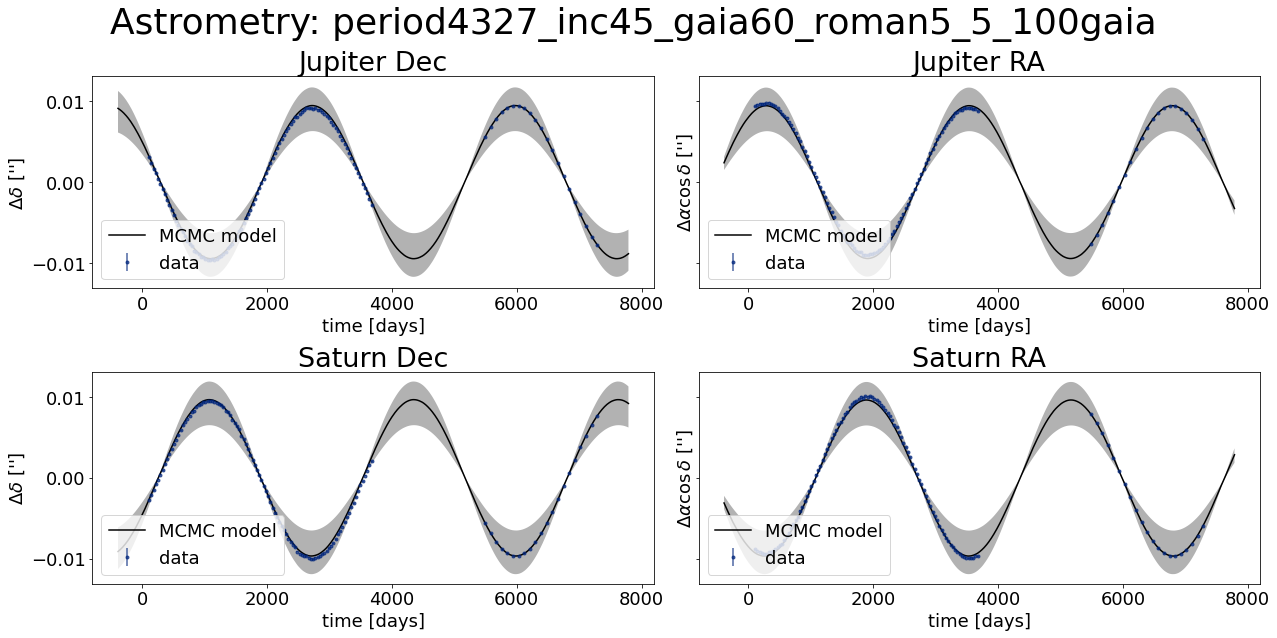

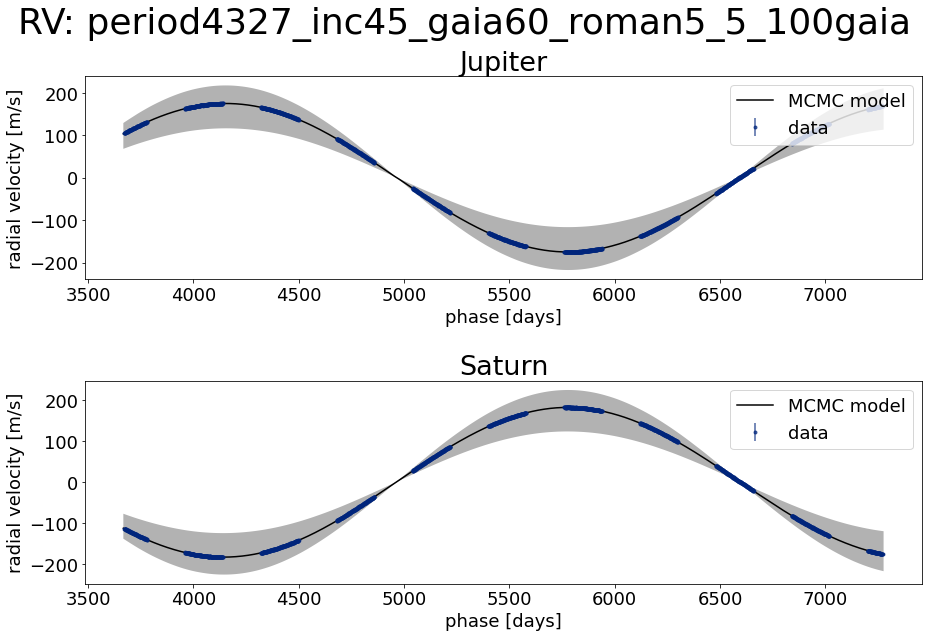

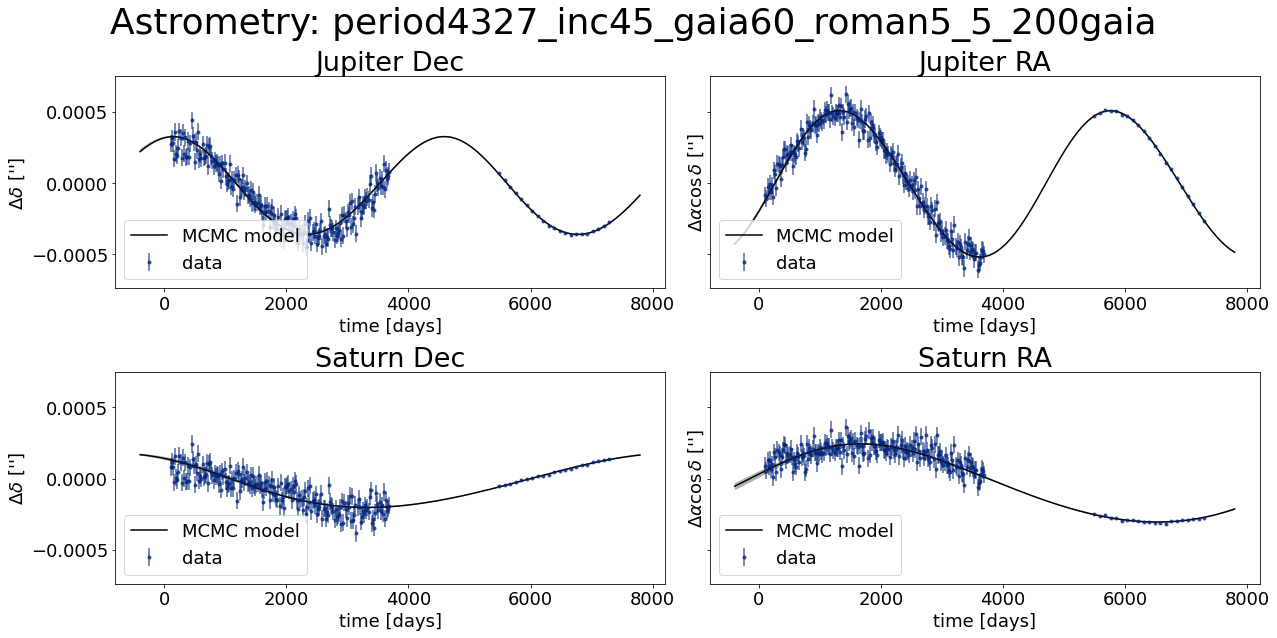

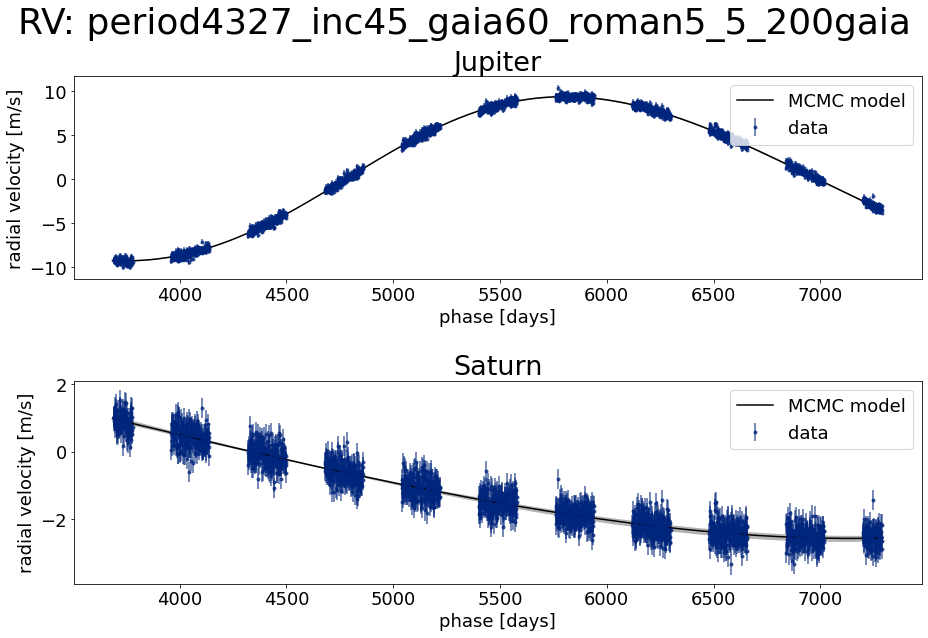

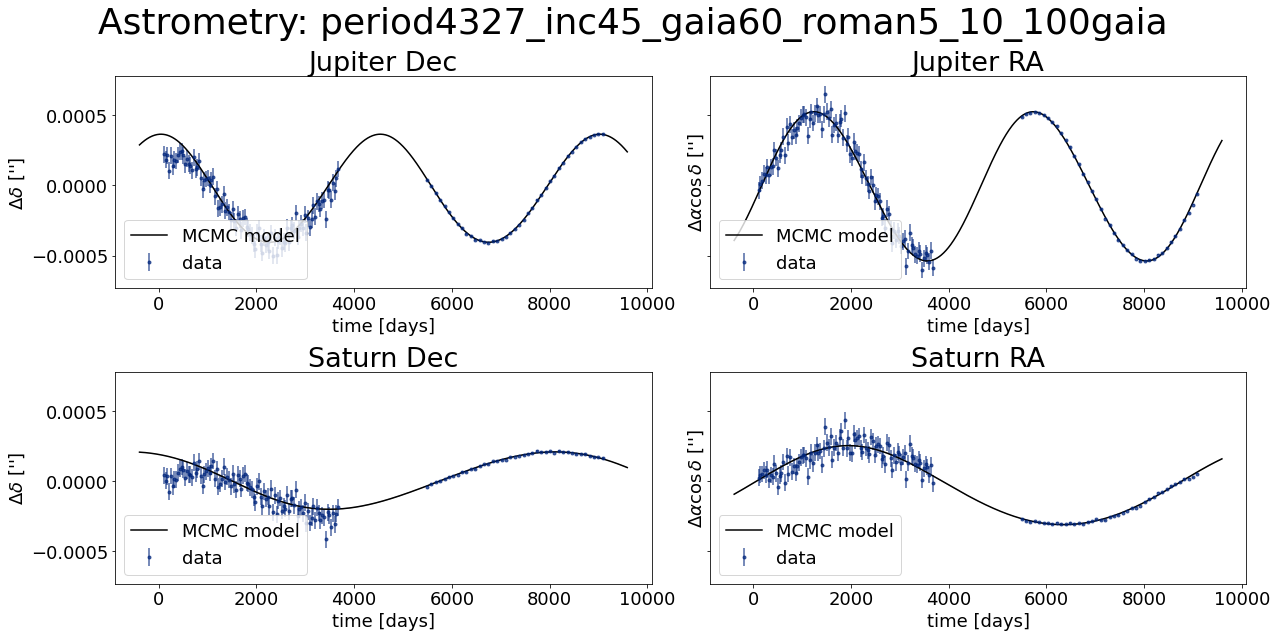

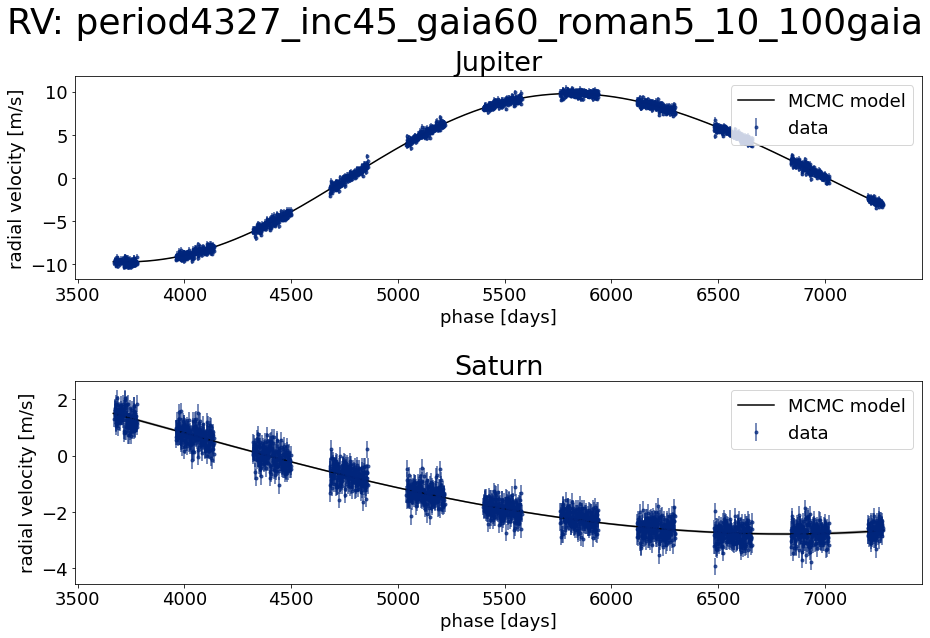

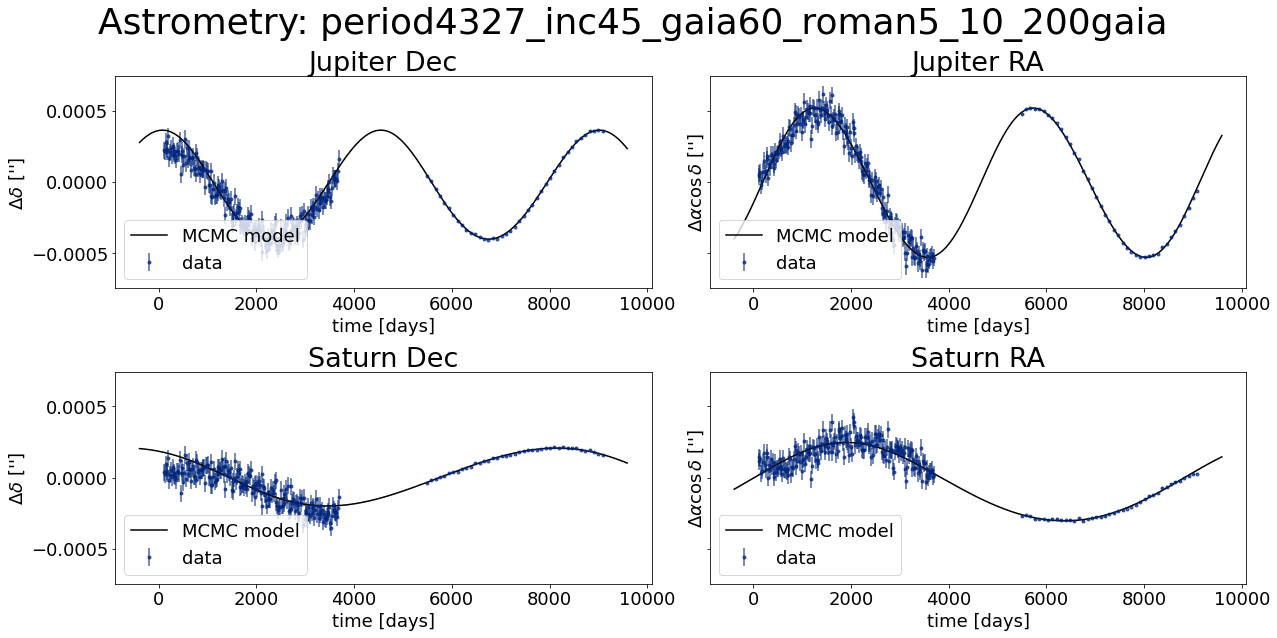

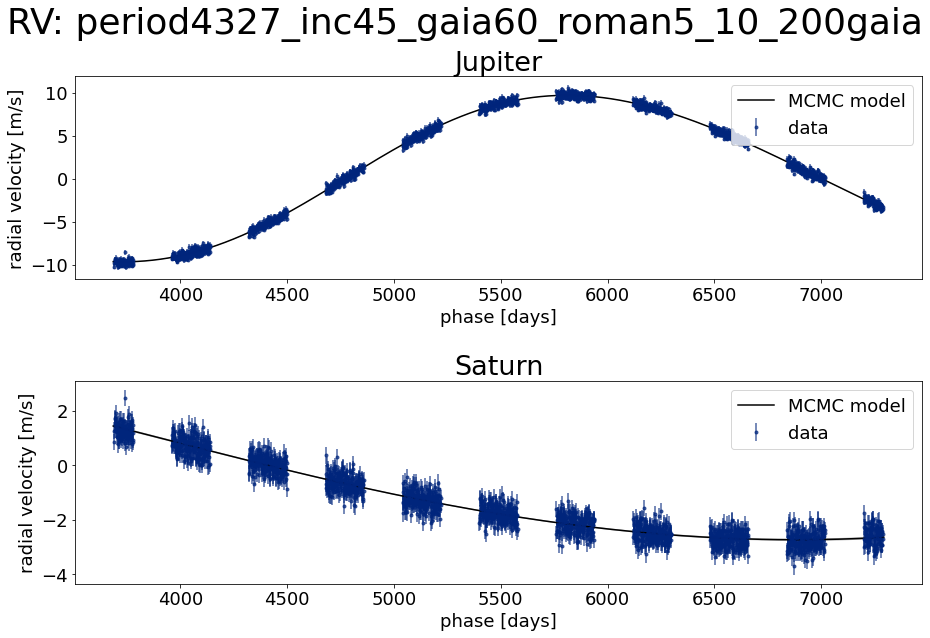

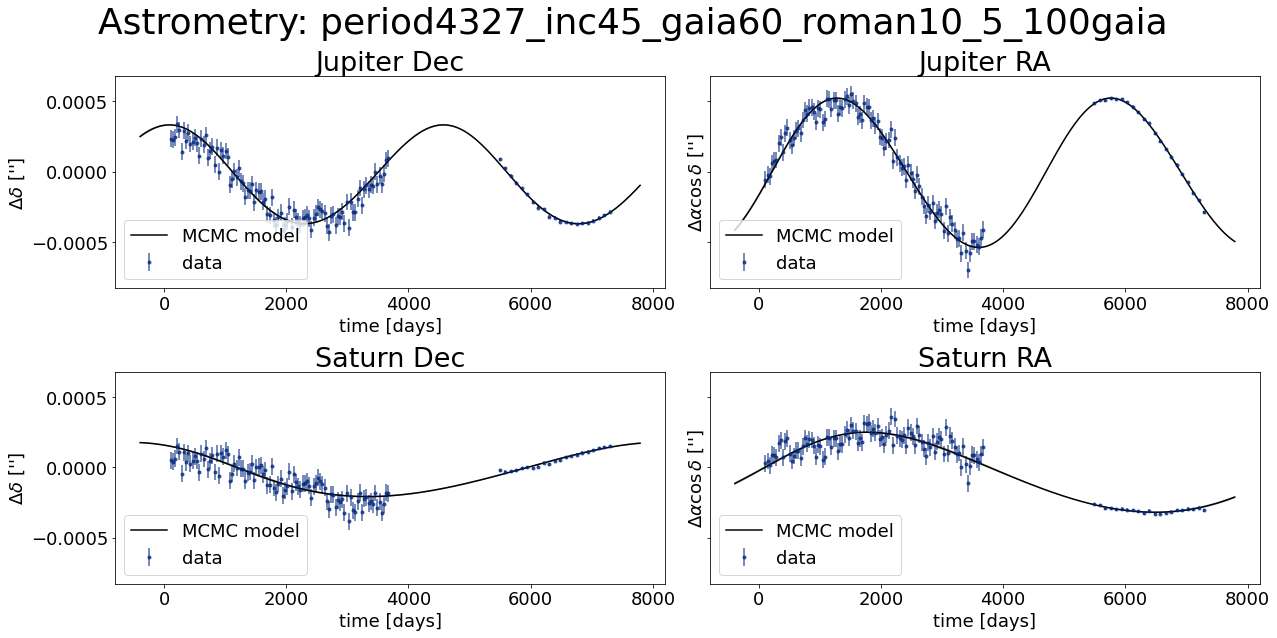

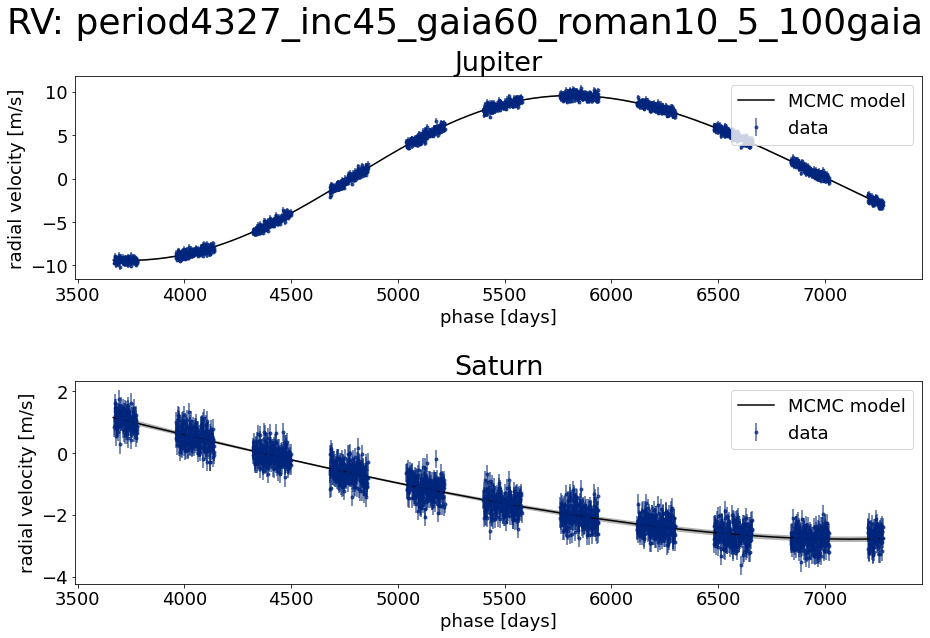

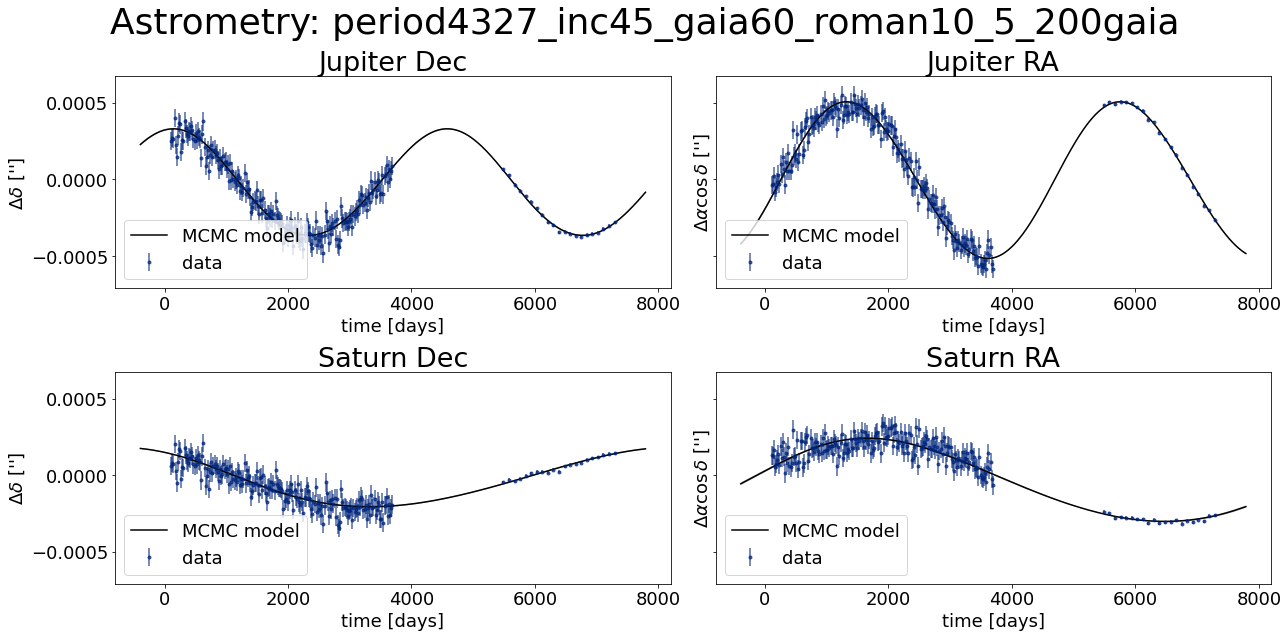

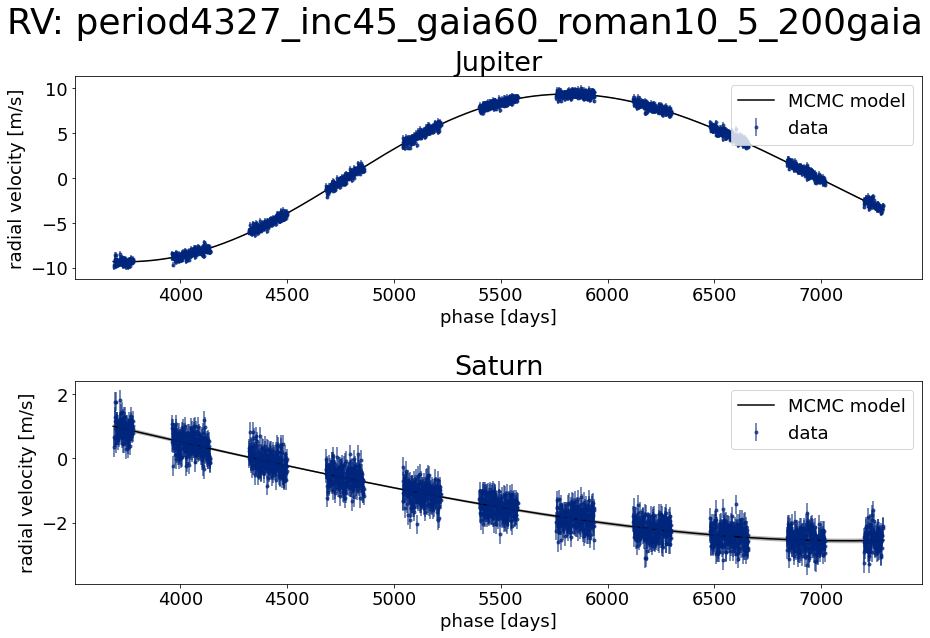

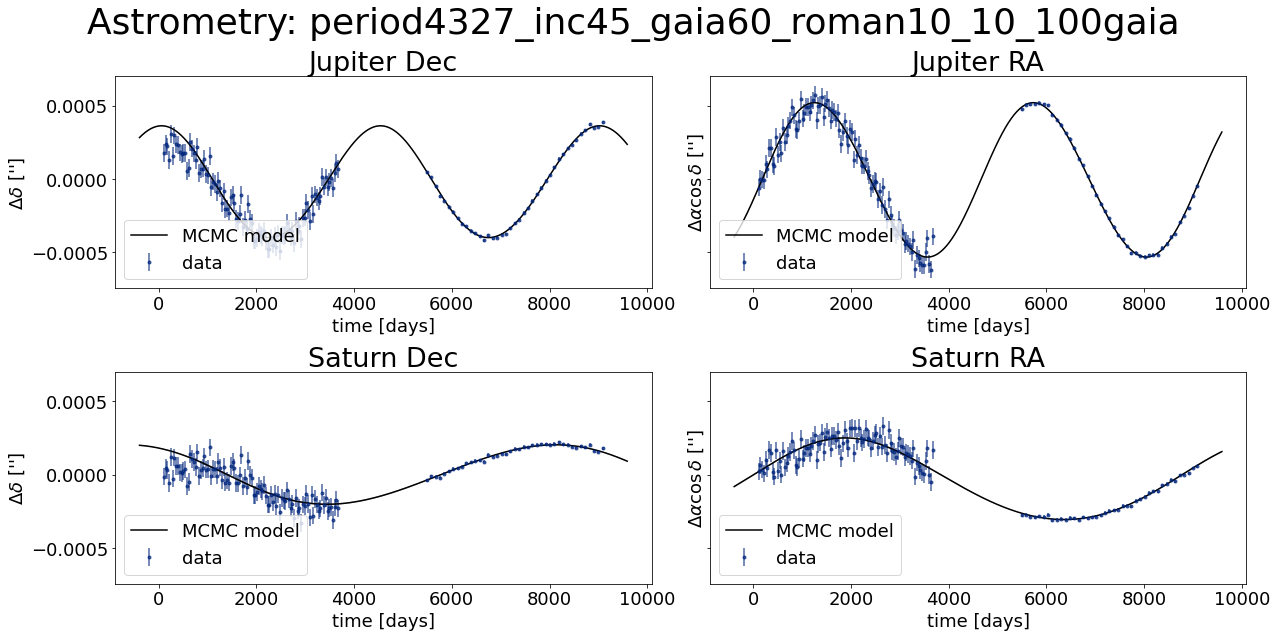

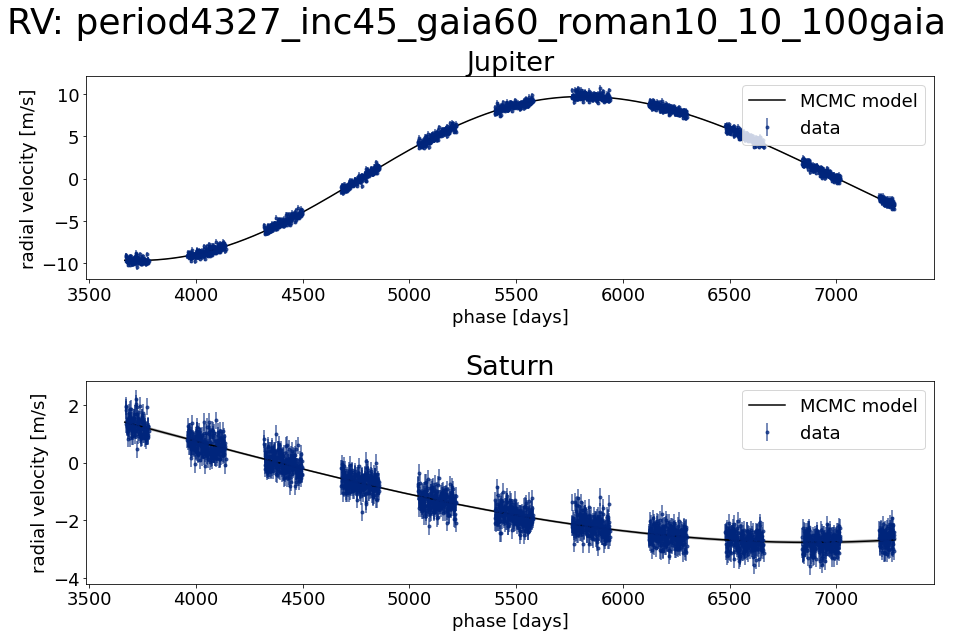

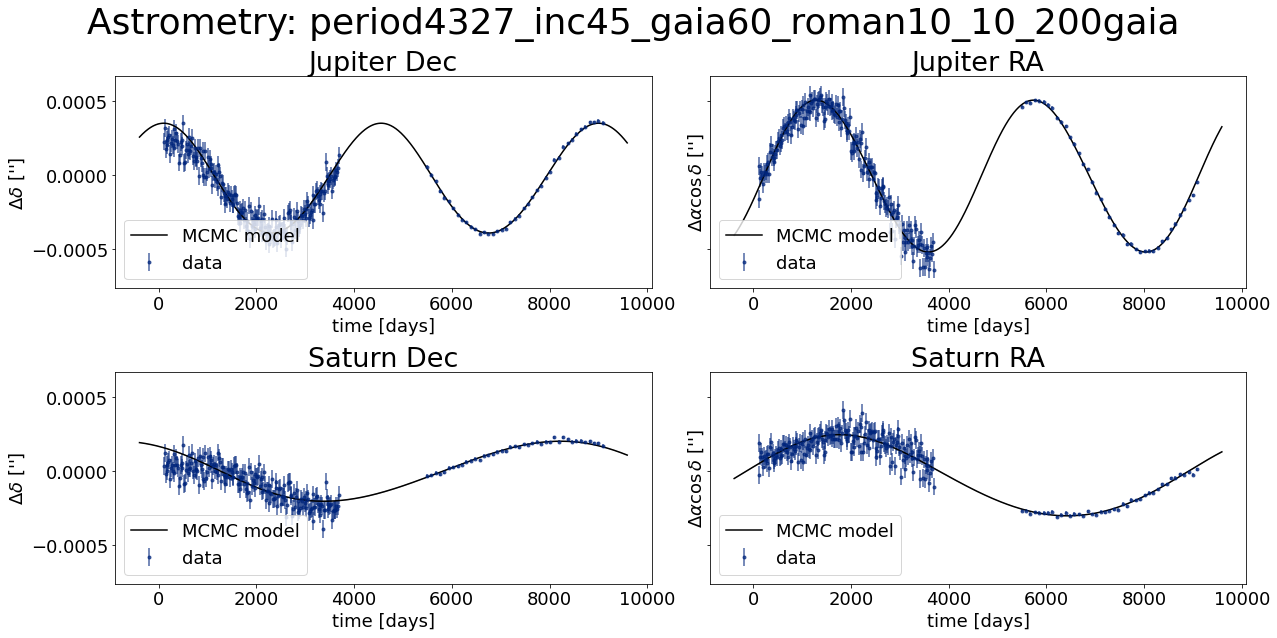

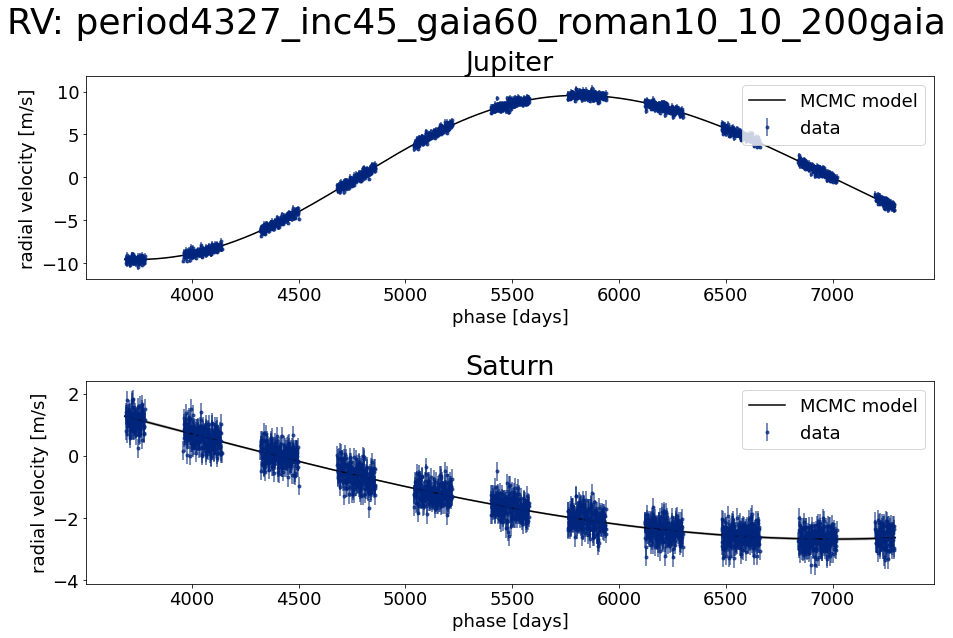

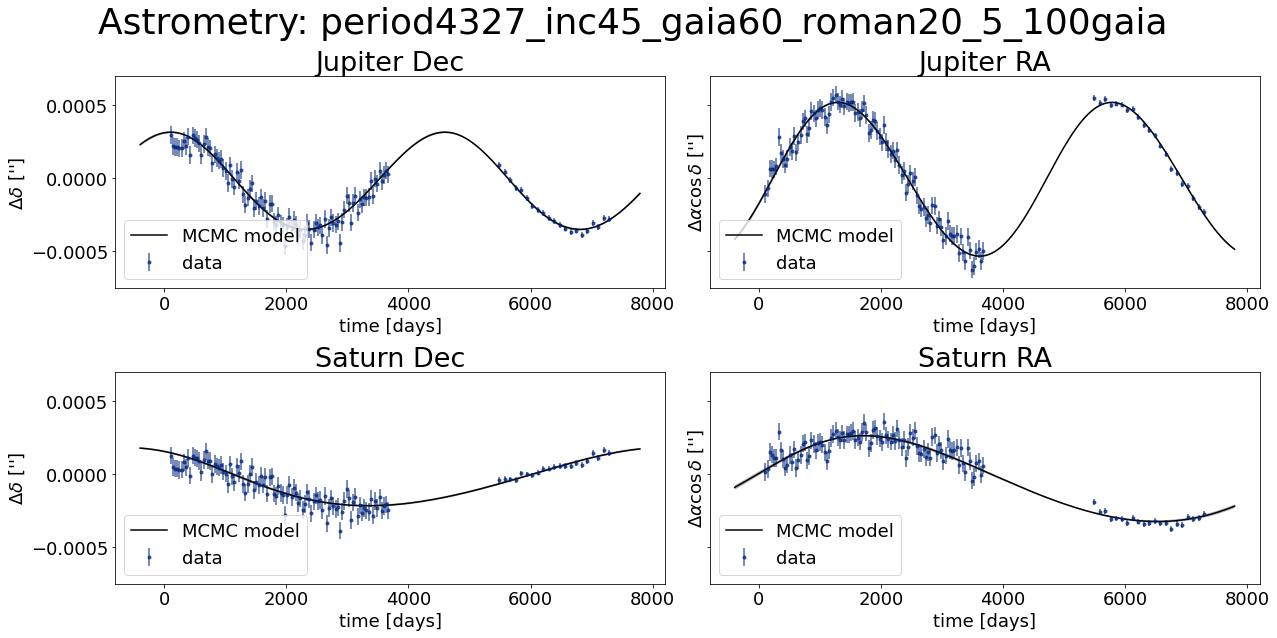

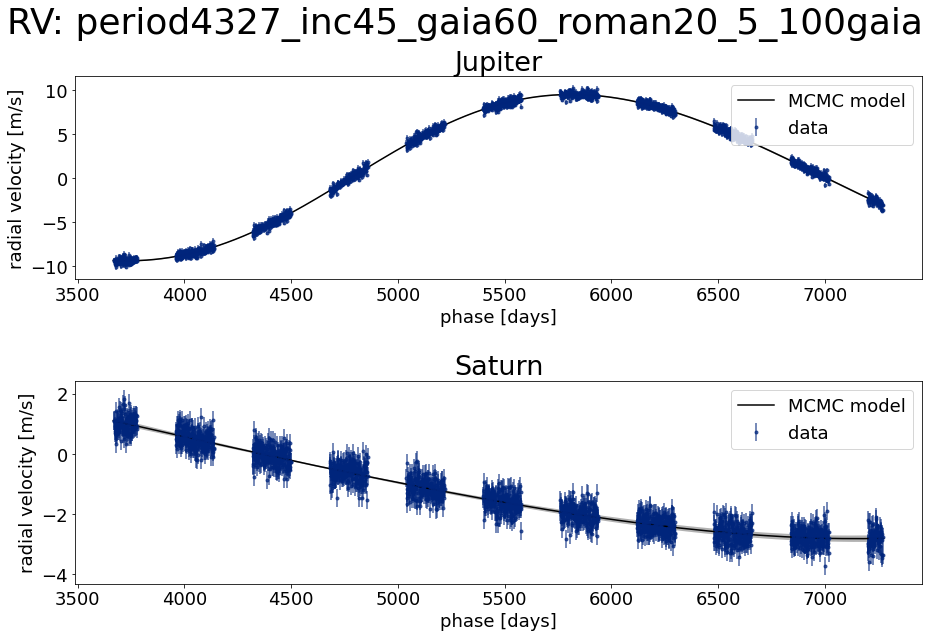

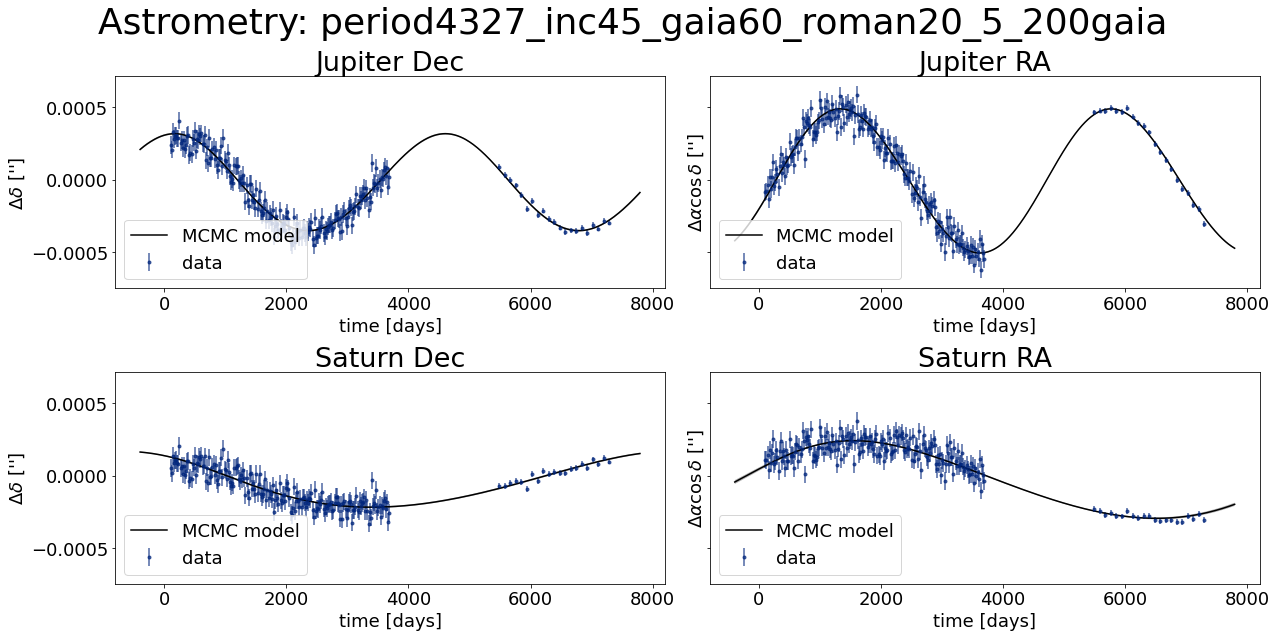

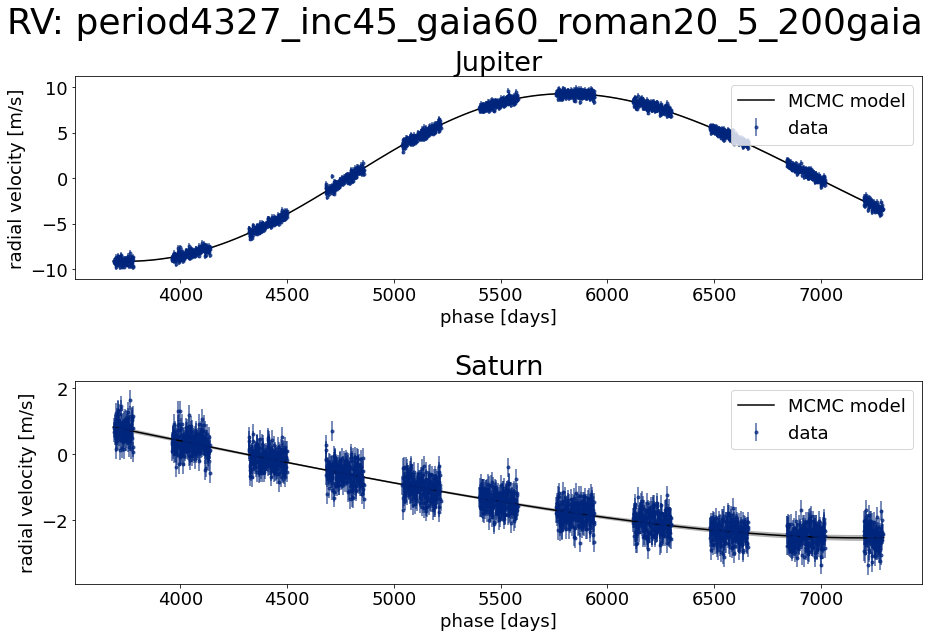

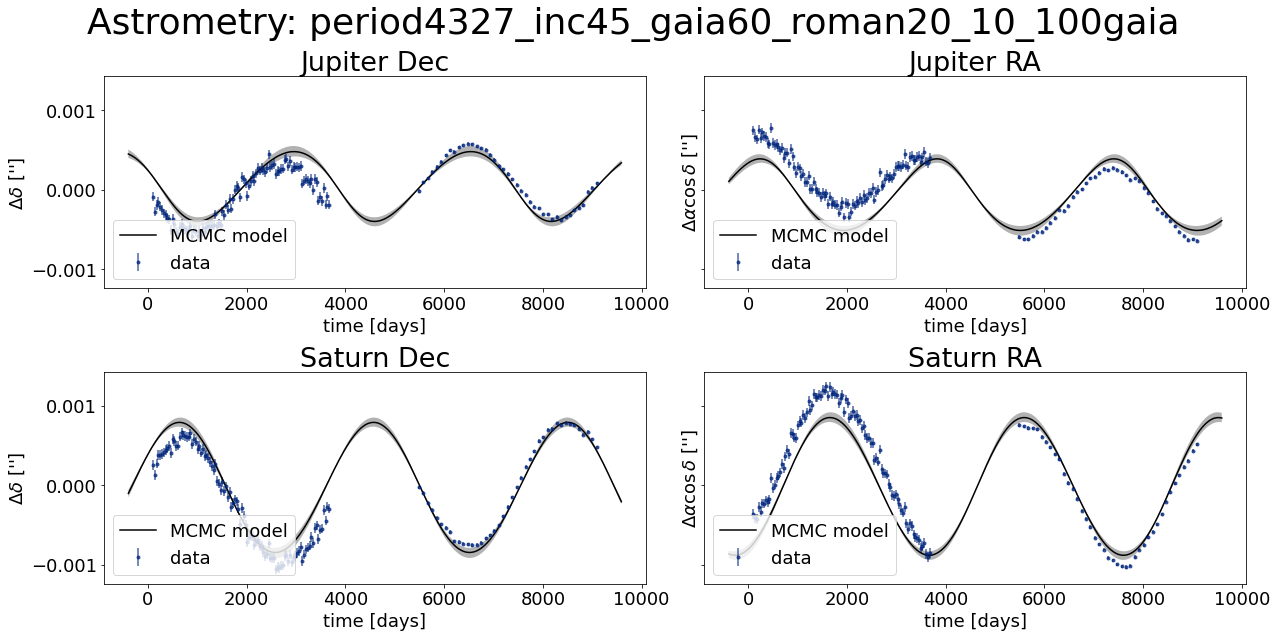

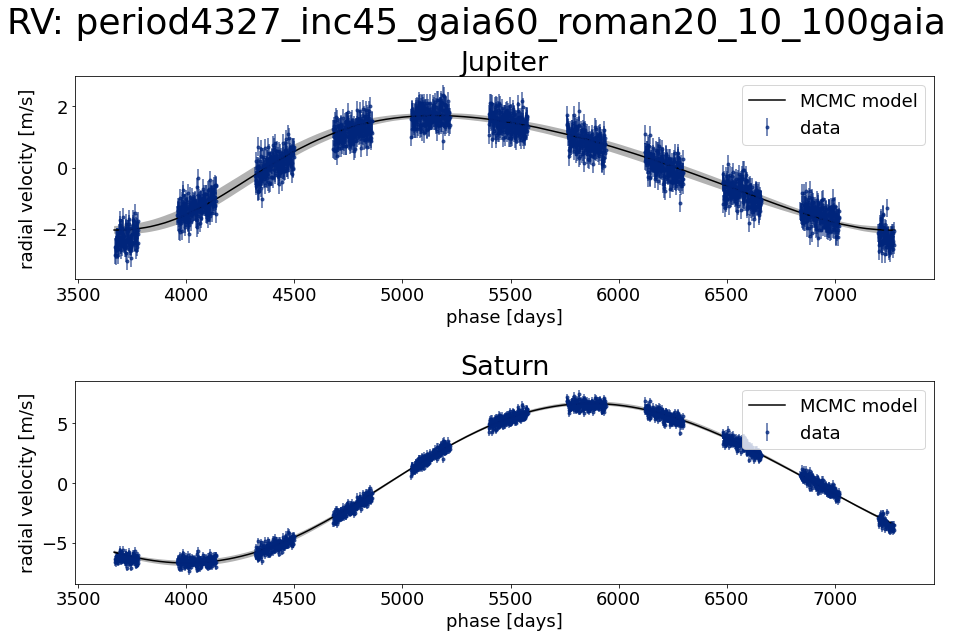

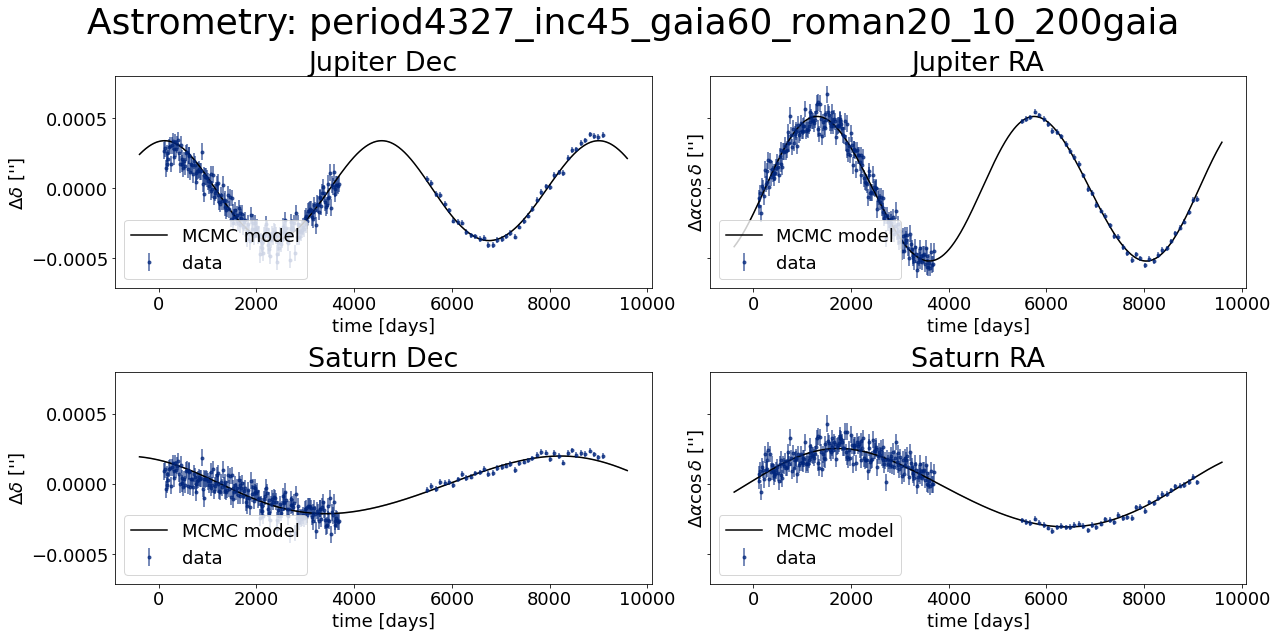

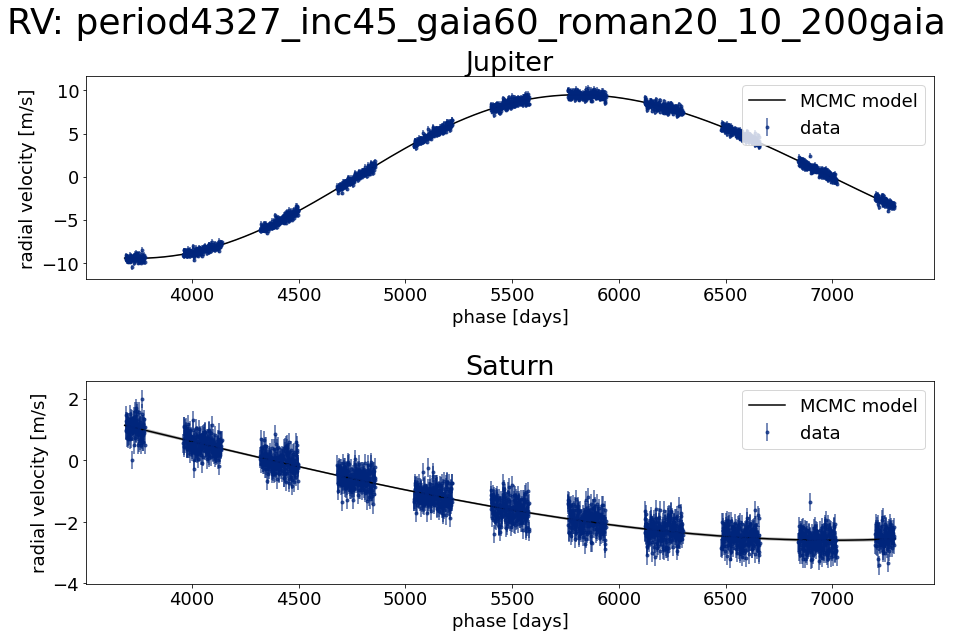

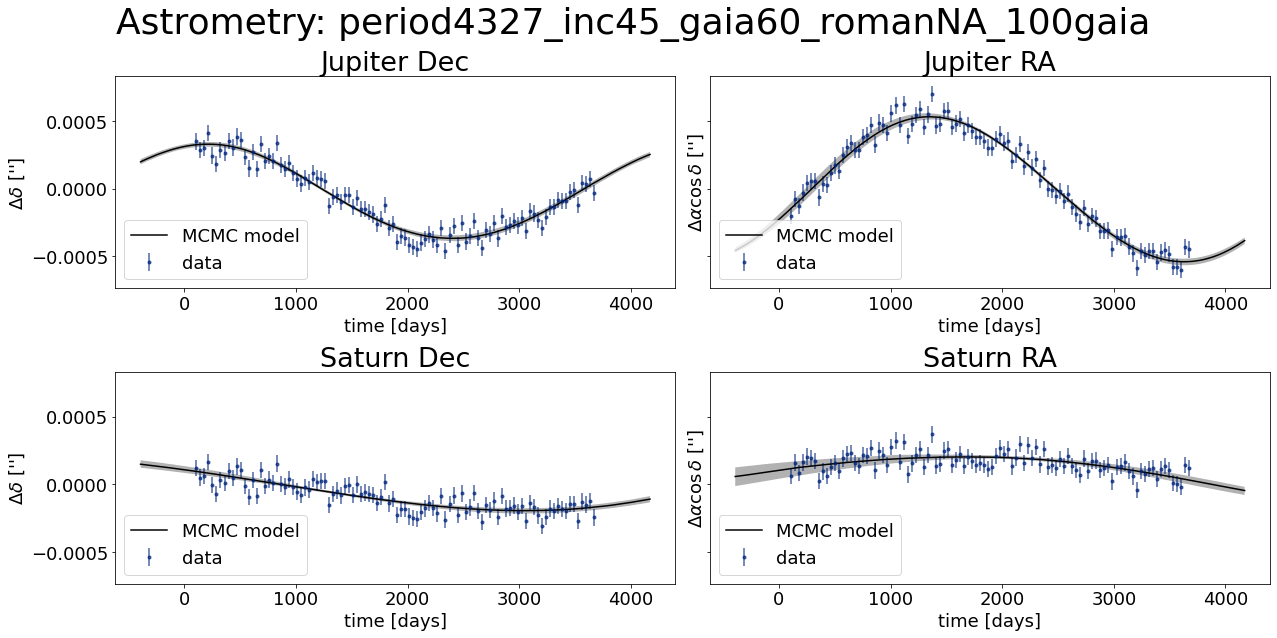

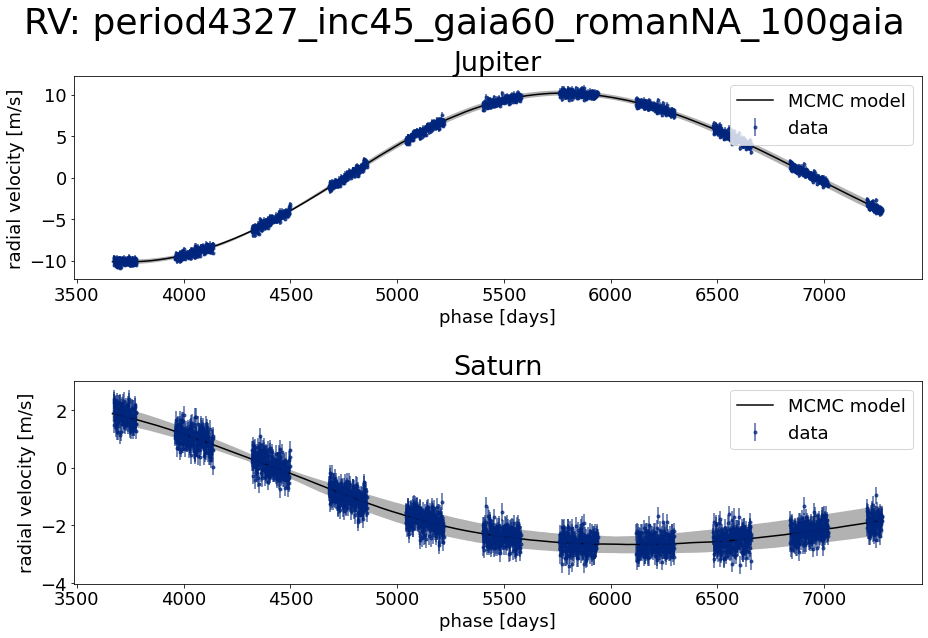

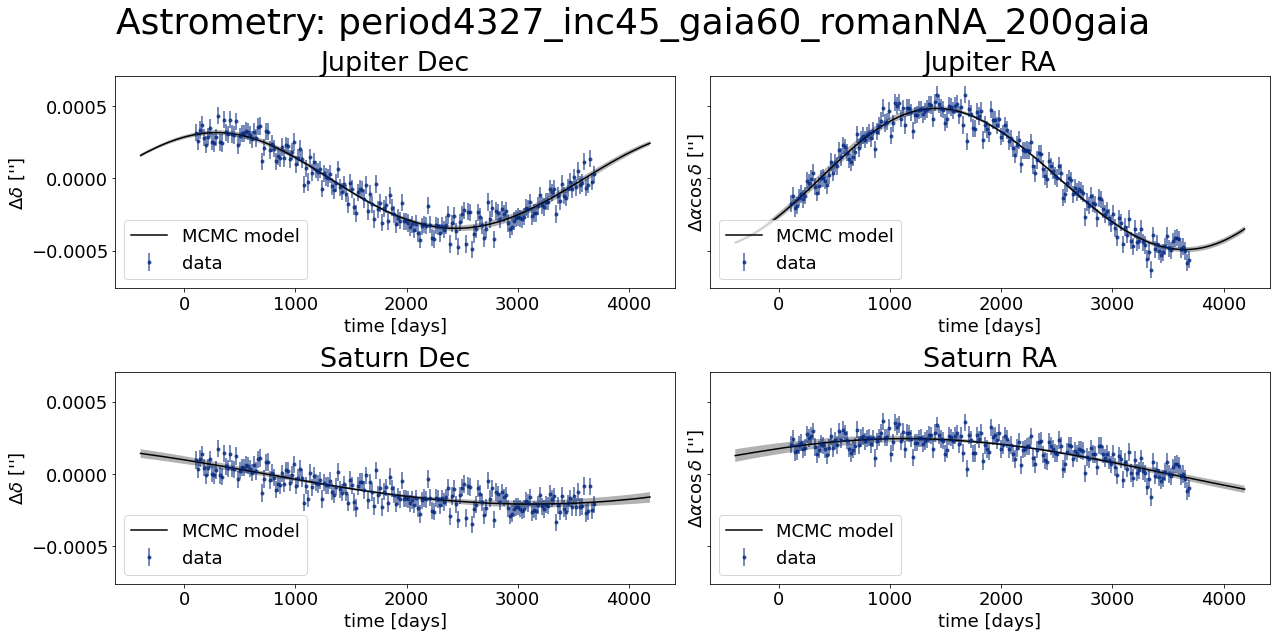

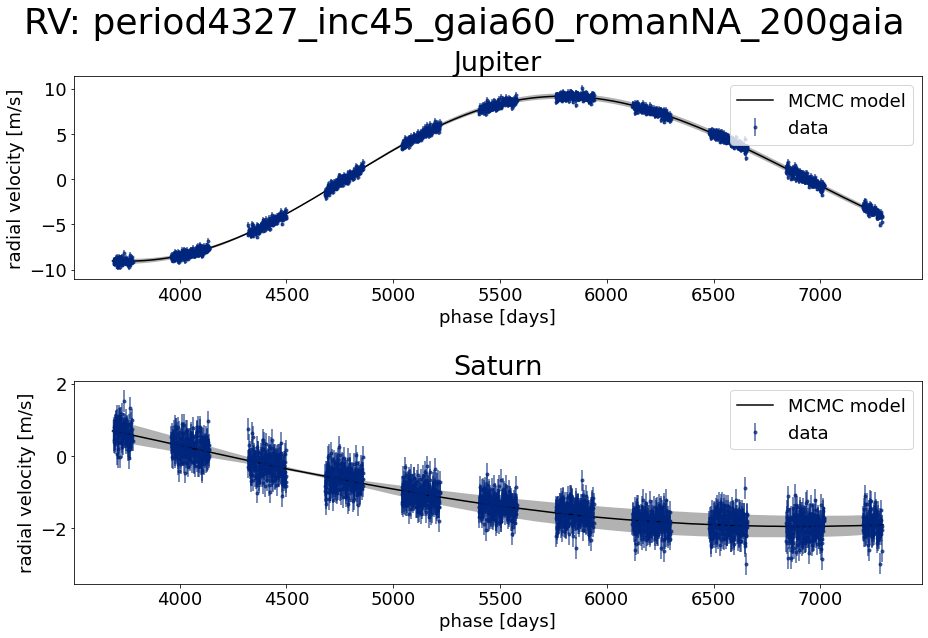

In [17]:
folder = './traces/March10_jup_and_saturn/'


files = [
    'period4327_inc45_gaia60_roman5_5_100gaia.cdf',
    'period4327_inc45_gaia60_roman5_5_200gaia.cdf',
    'period4327_inc45_gaia60_roman5_10_100gaia.cdf',
    'period4327_inc45_gaia60_roman5_10_200gaia.cdf',
    
    'period4327_inc45_gaia60_roman10_5_100gaia.cdf',
    'period4327_inc45_gaia60_roman10_5_200gaia.cdf',
    'period4327_inc45_gaia60_roman10_10_100gaia.cdf',
    'period4327_inc45_gaia60_roman10_10_200gaia.cdf',
    
    'period4327_inc45_gaia60_roman20_5_100gaia.cdf',
    'period4327_inc45_gaia60_roman20_5_200gaia.cdf',
    'period4327_inc45_gaia60_roman20_10_100gaia.cdf',
    'period4327_inc45_gaia60_roman20_10_200gaia.cdf',
    
    'period4327_inc45_gaia60_romanNA_100gaia.cdf',
    'period4327_inc45_gaia60_romanNA_200gaia.cdf',
]

period_jup = 4327
inc_earth = 45.0
roman_vars =[
    [5e-6,5],
    [5e-6,5],
    [5e-6,10],
    [5e-6,10],
    
    [10e-6,5],
    [10e-6,5],
    [10e-6,10],
    [10e-6,10],
    
    [20e-6,5],
    [20e-6,5],
    [20e-6,10],
    [20e-6,10],
    
    [None,None],
    [None,None]
]
gaia_obs = [100, 200]


P_earth = 300
e_earth = 0.0167
Tper_earth= 100
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(inc_earth)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = period_jup
e_jup = 0.0484
Tper_jup = 500
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


from matplotlib.backends.backend_pdf import PdfPages

for ii in range(0, len(roman_vars)):
    figs = make_plots(roman_vars[ii], simulated_data[ii], files[ii], folder)
    pp = PdfPages('comparison_figures2/diagnostic_jup+saturn'+str(ii+1)+'.pdf')
    pp.savefig(figs[1])
    pp.savefig(figs[0])
    pp.close()


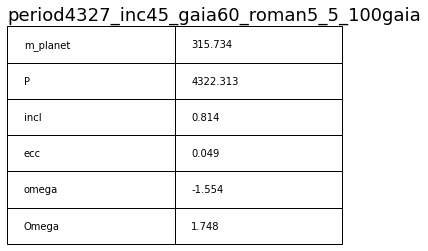

In [72]:
import pandas
fig, ax = plt.subplots()

jwst_table = {'test': 1, "testw": 2}
t=ax.table(cellText=np.column_stack((np.array(list(params_jup.keys())), np.round(np.array(list(params_jup.values())),3))),
           bbox=[0,0,1,1], colWidths=[1,1], cellLoc='left')
ax.set_title(file[:-4], fontsize=18, loc='left')
#t[(np.argmin(jwst_table.values), 0)].set_facecolor("#53b568")
#t[(np.argmin(jwst_table.values), 1)].set_facecolor("#53b568")
ax.set_axis_off()

In [59]:
print(np.array(list(params_earth_err.keys())))
print(np.array(list(params_earth_err.values())))

['m_planet' 'P' 'incl' 'ecc' 'omega' 'Omega']
[[[[0.2162211 ]
   [0.59632449]]]


 [[[1.98973473]
   [1.9302302 ]]]


 [[[0.46177153]
   [0.39168483]]]


 [[[0.10110526]
   [0.13210176]]]


 [[[1.00500931]
   [0.94706011]]]


 [[[2.0635542 ]
   [3.4625818 ]]]]


In [40]:
folder = './traces/Dec14/'


files = [
    'period4327_inc45_gaia60_roman5_5_100gaia.cdf',
    'period4327_inc45_gaia60_roman5_5_200gaia.cdf',
    'period4327_inc45_gaia60_roman5_10_100gaia.cdf',
    'period4327_inc45_gaia60_roman5_10_200gaia.cdf',
    
    'period4327_inc45_gaia60_roman10_5_100gaia.cdf',
    'period4327_inc45_gaia60_roman10_5_200gaia.cdf',
    'period4327_inc45_gaia60_roman10_10_100gaia.cdf',
    'period4327_inc45_gaia60_roman10_10_200gaia.cdf',
    
    'period4327_inc45_gaia60_roman20_5_100gaia.cdf',
    'period4327_inc45_gaia60_roman20_5_200gaia.cdf',
    'period4327_inc45_gaia60_roman20_10_100gaia.cdf',
    'period4327_inc45_gaia60_roman20_10_200gaia.cdf',
    
    'period4327_inc45_gaia60_romanNA_100gaia.cdf',
    'period4327_inc45_gaia60_romanNA_200gaia.cdf',
    'period4327_inc45_gaia60_romanNA_100gaia.cdf',
    'period4327_inc45_gaia60_romanNA_200gaia.cdf'
]

In [56]:
#periods = [1000., 4327.631, 10000.]
#incs = [10., 45., 80.]
#roman_errs = [5e-6, 10e-6, 20e-6, None]

periods_jup = [4327] #days
incs_earth = [45.] #degrees
roman_errs = [5e-6, 10e-6, 20e-6, None] #micro-as
roman_durations = [10, 5] #years
gaia_obs = [100, 200] #number of observations with Gaia


index = -1
params_earth = defaultdict(list)
params_jup = defaultdict(list)
params_earth_err = defaultdict(list)
params_jup_err = defaultdict(list)
#for inc in incs_earth:
    #for period in periods_jup:
        #for roman_err in roman_errs:
            #for roman_duration in roman_durations:
                #for gaia_ob in gaia_obs:
                    #index += 1
                    #file = files[index]
                    

file = files[0]
trace = arviz.from_netcdf(folder+file)


parameters = ["m_planet", "P", "incl", "ecc", "omega", "Omega"]

print('start')
print(file)
print('--------')
#print('Jupiter period: ' + str(int(period)))
#print('Earth inclination: ' + str(int(inc)))

#if roman_err is not None:
#    print('Roman precision: ' + str(int(1e6*roman_err)))
#    print('Roman duration: ' + str(int(roman_duration)))
#else:
#    print('Roman precision: N/A')
#    print('Roman duration: N/A')

#print('Gaia Obs: ' + str(int(gaia_ob)))

#print("")
#print("")
#print("")
for param in parameters:


    planet1_med = np.median(trace.posterior[param].values[:, :, 0])
    planet2_med = np.median(trace.posterior[param].values[:, :, 1])

    planet1_quantile = [np.quantile(trace.posterior[param].values[:, :, 0], 0.16),
                        np.quantile(trace.posterior[param].values[:, :, 0], 0.84)]

    planet2_quantile = [np.quantile(trace.posterior[param].values[:, :, 1], 0.16),
                        np.quantile(trace.posterior[param].values[:, :, 1], 0.84)]

    planet1_err = np.array([
        [planet1_med - planet1_quantile[0]  ],
        [planet1_quantile[1] - planet1_med]
    ])

    planet2_err = np.array([
        [planet2_med - planet2_quantile[0]  ],
        [planet2_quantile[1] - planet2_med]
    ])

    print(param + "_earth: " + str(planet1_med) + " -/+ " + str(planet1_err))
    print(param + "_jup: " + str(planet2_med) + "-/+" + str(planet2_err))

    params_earth[param].append(planet1_med)
    params_jup[param].append(planet2_med)

    params_earth_err[param].append(planet1_err)
    params_jup_err[param].append(planet2_err)

    print("")
    print("")


start
period4327_inc45_gaia60_roman5_5_100gaia.cdf
--------
m_planet_earth: 1.0044919344423962 -/+ [[0.2162211 ]
 [0.59632449]]
m_planet_jup: 315.7335749900299-/+[[1.69703064]
 [1.67207975]]


P_earth: 304.20747314745313 -/+ [[1.98973473]
 [1.9302302 ]]
P_jup: 4322.313411320585-/+[[3.32642873]
 [3.3312896 ]]


incl_earth: 1.014389322411805 -/+ [[0.46177153]
 [0.39168483]]
incl_jup: 0.8143564666146955-/+[[0.00570584]
 [0.00548689]]


ecc_earth: 0.14801590566446188 -/+ [[0.10110526]
 [0.13210176]]
ecc_jup: 0.04863030524095885-/+[[0.00142108]
 [0.001519  ]]


omega_earth: -0.1109008708409552 -/+ [[1.00500931]
 [0.94706011]]
omega_jup: -1.553533082139246-/+[[0.0311038 ]
 [0.03136883]]


Omega_earth: -0.4849436867215935 -/+ [[2.0635542]
 [3.4625818]]
Omega_jup: 1.7480608122857997-/+[[6.27991222]
 [0.00632895]]




In [57]:
params_earth

defaultdict(list,
            {'m_planet': [1.0044919344423962],
             'P': [304.20747314745313],
             'incl': [1.014389322411805],
             'ecc': [0.14801590566446188],
             'omega': [-0.1109008708409552],
             'Omega': [-0.4849436867215935]})